In [ ]:
!pip install etna

[ETNA](https://github.com/tinkoff-ai/etna/tree/master?tab=readme-ov-file) is an easy-to-use time series forecasting framework.

[Документация](https://docs.etna.ai/stable/index.html)

### Импорты

In [ ]:
import pandas as pd

from etna.datasets import TSDataset
from etna.models import NaiveModel, MovingAverageModel, CatBoostMultiSegmentModel
from etna.analysis import plot_forecast
from etna.metrics import MAE, MSE, SMAPE
from etna.transforms import MeanTransform, LagTransform, StandardScalerTransform

### Загрузка данных

In [ ]:
df = pd.read_csv('monthly-australian-wine-sales.csv', parse_dates=['month'])
df.head()

,month,sales
0,1980-01-01,15136
1,1980-02-01,16733
2,1980-03-01,20016
3,1980-04-01,17708
4,1980-05-01,18019


In [ ]:
df = df.rename(columns={'month': 'timestamp', 'sales': 'target'})
df['segment'] = 'main'
df.head()

,timestamp,target,segment
0,1980-01-01,15136,main
1,1980-02-01,16733,main
2,1980-03-01,20016,main
3,1980-04-01,17708,main
4,1980-05-01,18019,main


In [ ]:
ts = TSDataset(df, freq='MS')
ts.head()

segment,main
feature,target
timestamp,
1980-01-01,15136
1980-02-01,16733
1980-03-01,20016
1980-04-01,17708
1980-05-01,18019


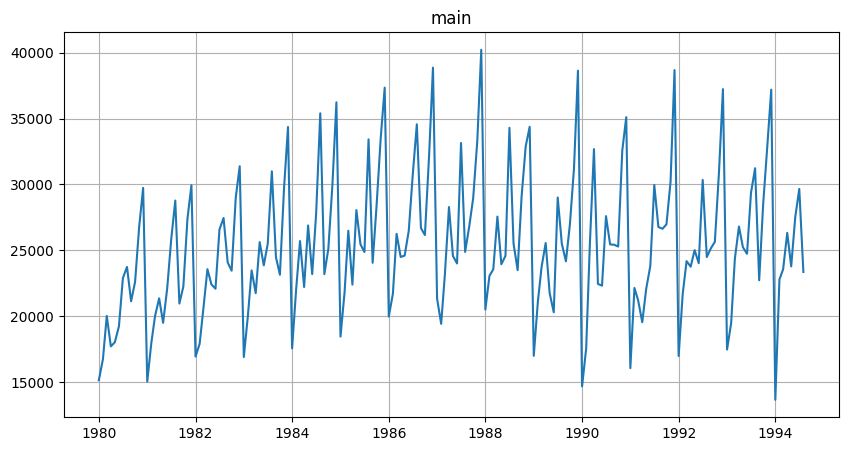

In [ ]:
ts.plot()

In [ ]:
ts.describe()

,start_timestamp,end_timestamp,length,num_missing,num_segments,num_exogs,num_regressors,num_known_future,freq
segments,,,,,,,,,
main,1980-01-01,1994-08-01,176,0,1,0,0,0,MS


### Train-test split

In [ ]:
train_ts, test_ts = ts.train_test_split(
    train_start='1980-01-01',
    train_end='1993-12-01',
    test_start='1994-01-01',
    test_end='1994-08-01'
)

In [ ]:
def fit_model(model, train_ts, horizon):
  model.fit(train_ts)

  future_ts = train_ts.make_future(future_steps=horizon, tail_steps=model.context_size)
  return future_ts

In [ ]:
HORIZON = 8

### Наивный прогноз

In [ ]:
model = NaiveModel()
future_ts = fit_model(model, train_ts, HORIZON)
future_ts

segment,main
feature,target
timestamp,
1993-12-01,37198.0
1994-01-01,NaN
1994-02-01,NaN
1994-03-01,NaN
1994-04-01,NaN
1994-05-01,NaN
1994-06-01,NaN
1994-07-01,NaN


In [ ]:
forecast_ts = model.forecast(future_ts, prediction_size=HORIZON)
forecast_ts

segment,main
feature,target
timestamp,
1994-01-01,37198.0
1994-02-01,37198.0
1994-03-01,37198.0
1994-04-01,37198.0
1994-05-01,37198.0
1994-06-01,37198.0
1994-07-01,37198.0
1994-08-01,37198.0


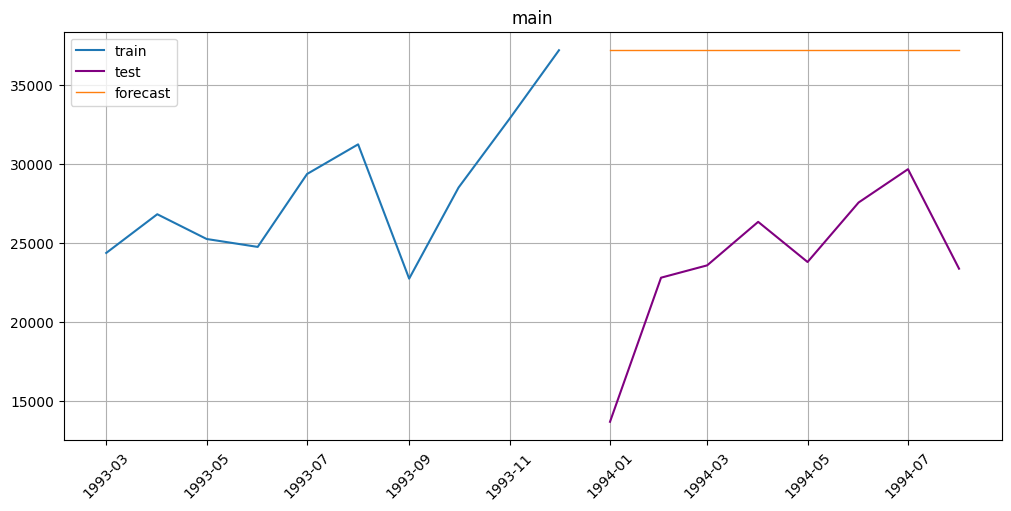

In [ ]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=10)

In [ ]:
for metric in [SMAPE(), MAE(), MSE()]:
  print(f"Metric {metric.name}: {metric(y_true=test_ts, y_pred=forecast_ts)['main']}")

Metric SMAPE: 45.233722723374306
Metric MAE: 13364.5
Metric MSE: 198487124.5


### MovingAverageModel - скользящее среднее

In [ ]:
model = MovingAverageModel(window=5)
future_ts = fit_model(model, train_ts, HORIZON)
forecast_ts = model.forecast(future_ts, prediction_size=HORIZON)
forecast_ts

segment,main
feature,target
timestamp,
1994-01-01,30501.800000
1994-02-01,30355.360000
1994-03-01,31881.632000
1994-04-01,32558.758400
1994-05-01,32499.110080
1994-06-01,31559.332096
1994-07-01,31770.838515
1994-08-01,32053.934218


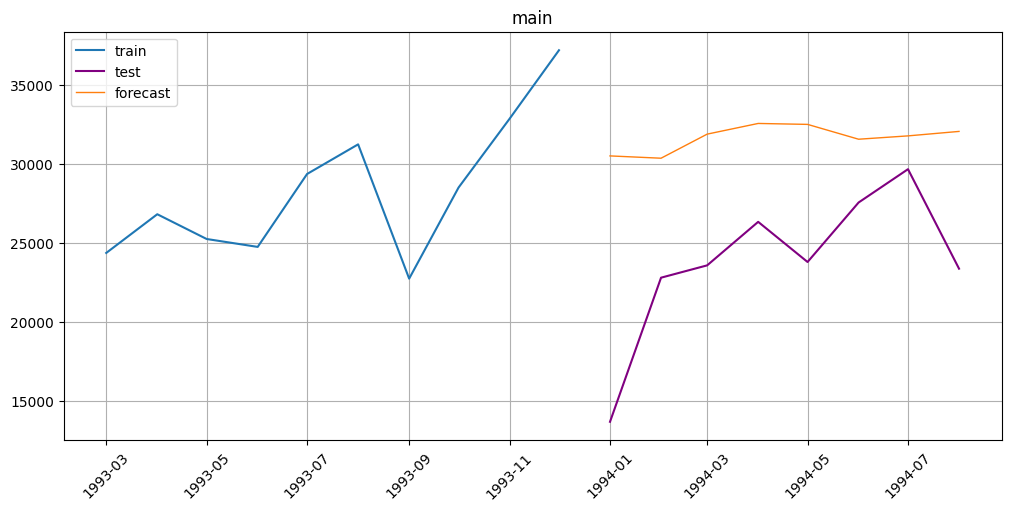

In [ ]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=10)

In [ ]:
for metric in [SMAPE(), MAE(), MSE()]:
  print(f"Metric {metric.name}: {metric(y_true=test_ts, y_pred=forecast_ts)['main']}")

Metric SMAPE: 29.85307984438601
Metric MAE: 7814.095663680002
Metric MSE: 77690635.64572527


### CatBoostMultiSegmentModel

In [ ]:
lags = LagTransform(in_column="target", lags=list(range(8, 24, 1)))
mean = MeanTransform(in_column="target", window=8)

transforms = [lags, mean]
train_ts.fit_transform(transforms)
train_ts.head()

segment                                                                    main  \
feature    LagTransform(in_column = 'target', lags = [10], out_column = None, )   
timestamp                                                                         
1980-01-01                                                NaN                     
1980-02-01                                                NaN                     
1980-03-01                                                NaN                     
1980-04-01                                                NaN                     
1980-05-01                                                NaN                     

segment                                                                          \
feature    LagTransform(in_column = 'target', lags = [11], out_column = None, )   
timestamp                                                                         
1980-01-01                                                NaN                     
1980-02-01                                                NaN                     
1980-03-01                                                NaN                     
1980-04-01                                                NaN                     
1980-05-01                                                NaN                     

segment                                                                          \
feature    LagTransform(in_column = 'target', lags = [12], out_column = None, )   
timestamp                                                                         
1980-01-01                                                NaN                     
1980-02-01                                                NaN                     
1980-03-01                                                NaN                     
1980-04-01                                                NaN                     
1980-05-01                                                NaN                     

segment                                                                          \
feature    LagTransform(in_column = 'target', lags = [13], out_column = None, )   
timestamp                                                                         
1980-01-01                                                NaN                     
1980-02-01                                                NaN                     
1980-03-01                                                NaN                     
1980-04-01                                                NaN                     
1980-05-01                                                NaN                     

segment                                                                          \
feature    LagTransform(in_column = 'target', lags = [14], out_column = None, )   
timestamp                                                                         
1980-01-01                                                NaN                     
1980-02-01                                                NaN                     
1980-03-01                                                NaN                     
1980-04-01                                                NaN                     
1980-05-01                                                NaN                     

segment                                                                          \
feature    LagTransform(in_column = 'target', lags = [15], out_column = None, )   
timestamp                                                                         
1980-01-01                                                NaN                     
1980-02-01                                                NaN                     
1980-03-01                                                NaN                     
1980-04-01                                                NaN                     
1980-05-01                                                NaN                     

segment   

In [ ]:
train_ts.tail()

segment                                                                    main  \
feature    LagTransform(in_column = 'target', lags = [10], out_column = None, )   
timestamp                                                                         
1993-08-01                                            25650.0                     
1993-09-01                                            30923.0                     
1993-10-01                                            37240.0                     
1993-11-01                                            17466.0                     
1993-12-01                                            19463.0                     

segment                                                                          \
feature    LagTransform(in_column = 'target', lags = [11], out_column = None, )   
timestamp                                                                         
1993-08-01                                            25156.0                     
1993-09-01                                            25650.0                     
1993-10-01                                            30923.0                     
1993-11-01                                            37240.0                     
1993-12-01                                            17466.0                     

segment                                                                          \
feature    LagTransform(in_column = 'target', lags = [12], out_column = None, )   
timestamp                                                                         
1993-08-01                                            24488.0                     
1993-09-01                                            25156.0                     
1993-10-01                                            25650.0                     
1993-11-01                                            30923.0                     
1993-12-01                                            37240.0                     

segment                                                                          \
feature    LagTransform(in_column = 'target', lags = [13], out_column = None, )   
timestamp                                                                         
1993-08-01                                            30345.0                     
1993-09-01                                            24488.0                     
1993-10-01                                            25156.0                     
1993-11-01                                            25650.0                     
1993-12-01                                            30923.0                     

segment                                                                          \
feature    LagTransform(in_column = 'target', lags = [14], out_column = None, )   
timestamp                                                                         
1993-08-01                                            24019.0                     
1993-09-01                                            30345.0                     
1993-10-01                                            24488.0                     
1993-11-01                                            25156.0                     
1993-12-01                                            25650.0                     

segment                                                                          \
feature    LagTransform(in_column = 'target', lags = [15], out_column = None, )   
timestamp                                                                         
1993-08-01                                            25013.0                     
1993-09-01                                            24019.0                     
1993-10-01                                            30345.0                     
1993-11-01                                            24488.0                     
1993-12-01                                            25156.0                     

segment   

In [ ]:
model = CatBoostMultiSegmentModel()
model.fit(train_ts)

CatBoostMultiSegmentModel(iterations = None, depth = None, learning_rate = None, logging_level = 'Silent', l2_leaf_reg = None, thread_count = None, )

In [ ]:
future_ts = train_ts.make_future(future_steps=HORIZON, transforms=transforms)
future_ts

segment                                                                    main  \
feature    LagTransform(in_column = 'target', lags = [10], out_column = None, )   
timestamp                                                                         
1994-01-01                                            24352.0                     
1994-02-01                                            26805.0                     
1994-03-01                                            25236.0                     
1994-04-01                                            24735.0                     
1994-05-01                                            29356.0                     
1994-06-01                                            31234.0                     
1994-07-01                                            22724.0                     
1994-08-01                                            28496.0                     

segment                                                                          \
feature    LagTransform(in_column = 'target', lags = [11], out_column = None, )   
timestamp                                                                         
1994-01-01                                            19463.0                     
1994-02-01                                            24352.0                     
1994-03-01                                            26805.0                     
1994-04-01                                            25236.0                     
1994-05-01                                            24735.0                     
1994-06-01                                            29356.0                     
1994-07-01                                            31234.0                     
1994-08-01                                            22724.0                     

segment                                                                          \
feature    LagTransform(in_column = 'target', lags = [12], out_column = None, )   
timestamp                                                                         
1994-01-01                                            17466.0                     
1994-02-01                                            19463.0                     
1994-03-01                                            24352.0                     
1994-04-01                                            26805.0                     
1994-05-01                                            25236.0                     
1994-06-01                                            24735.0                     
1994-07-01                                            29356.0                     
1994-08-01                                            31234.0                     

segment                                                                          \
feature    LagTransform(in_column = 'target', lags = [13], out_column = None, )   
timestamp                                                                         
1994-01-01                                            37240.0                     
1994-02-01                                            17466.0                     
1994-03-01                                            19463.0                     
1994-04-01                                            24352.0                     
1994-05-01                                            26805.0                     
1994-06-01                                            25236.0                     
1994-07-01                                            24735.0                     
1994-08-01                                            29356.0                     

segment                                                                          \
feature    LagTransform(in_column = 'target', lags = [14], out_column = None, )   
timestamp                                                                         
1994-01-01                                            30923.0                     
1994-02-01  

In [ ]:
forecast_ts = model.forecast(future_ts)
forecast_ts.inverse_transform(transforms)
forecast_ts

segment                                                                    main  \
feature    LagTransform(in_column = 'target', lags = [10], out_column = None, )   
timestamp                                                                         
1994-01-01                                            24352.0                     
1994-02-01                                            26805.0                     
1994-03-01                                            25236.0                     
1994-04-01                                            24735.0                     
1994-05-01                                            29356.0                     
1994-06-01                                            31234.0                     
1994-07-01                                            22724.0                     
1994-08-01                                            28496.0                     

segment                                                                          \
feature    LagTransform(in_column = 'target', lags = [11], out_column = None, )   
timestamp                                                                         
1994-01-01                                            19463.0                     
1994-02-01                                            24352.0                     
1994-03-01                                            26805.0                     
1994-04-01                                            25236.0                     
1994-05-01                                            24735.0                     
1994-06-01                                            29356.0                     
1994-07-01                                            31234.0                     
1994-08-01                                            22724.0                     

segment                                                                          \
feature    LagTransform(in_column = 'target', lags = [12], out_column = None, )   
timestamp                                                                         
1994-01-01                                            17466.0                     
1994-02-01                                            19463.0                     
1994-03-01                                            24352.0                     
1994-04-01                                            26805.0                     
1994-05-01                                            25236.0                     
1994-06-01                                            24735.0                     
1994-07-01                                            29356.0                     
1994-08-01                                            31234.0                     

segment                                                                          \
feature    LagTransform(in_column = 'target', lags = [13], out_column = None, )   
timestamp                                                                         
1994-01-01                                            37240.0                     
1994-02-01                                            17466.0                     
1994-03-01                                            19463.0                     
1994-04-01                                            24352.0                     
1994-05-01                                            26805.0                     
1994-06-01                                            25236.0                     
1994-07-01                                            24735.0                     
1994-08-01                                            29356.0                     

segment                                                                          \
feature    LagTransform(in_column = 'target', lags = [14], out_column = None, )   
timestamp                                                                         
1994-01-01                                            30923.0                     
1994-02-01  

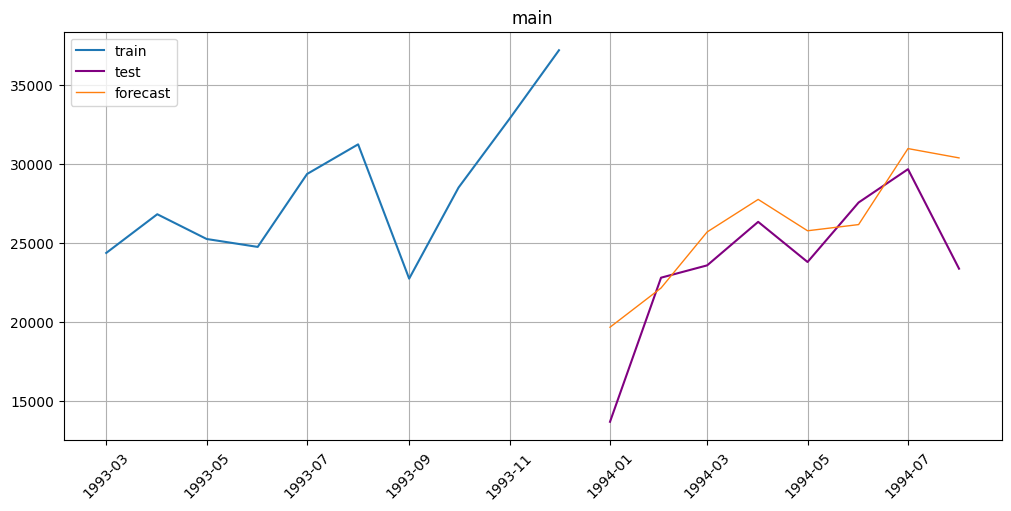

In [ ]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=10)

In [ ]:
for metric in [SMAPE(), MAE(), MSE()]:
  print(f"Metric {metric.name}: {metric(y_true=test_ts, y_pred=forecast_ts)['main']}")

Metric SMAPE: 12.050245873517477
Metric MAE: 2736.1241464868426
Metric MSE: 12462511.96909982
